In [2]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
import optax


import pickle as pkl

import itertools
import more_itertools as mit

import os

from alive_progress import alive_bar
import gc

import matplotlib.pyplot as plt

parallel_scan = jax.lax.associative_scan

In [3]:
def binary_operator_diag(element_i, element_j):
    a_i, bu_i = element_i
    a_j, bu_j = element_j

    return a_j * a_i, a_j * bu_i + bu_j


def init_lru_parameters(N, H, r_min = 0.0, r_max = 1, max_phase = 6.28):
    # N: state dimension, H: model dimension
    # Initialization of Lambda is complex valued distributed uniformly on ring
    # between r_min and r_max, with phase in [0, max_phase].

    u1 = np.random.uniform(size = (N,))
    u2 = np.random.uniform(size = (N,))

    nu_log = np.log(-0.5*np.log(u1*(r_max**2-r_min**2) + r_min**2))
    theta_log = np.log(max_phase*u2)

    # Glorot initialized Input/Output projection matrices
    B_re = np.random.normal(size=(N,H))/np.sqrt(2*H)
    B_im = np.random.normal(size=(N,H))/np.sqrt(2*H)
    C_re = np.random.normal(size=(H,N))/np.sqrt(N)
    C_im = np.random.normal(size=(H,N))/np.sqrt(N)
    D = np.random.normal(size=(H,))

    # Normalization
    diag_lambda = np.exp(-np.exp(nu_log) + 1j*np.exp(theta_log))
    gamma_log = np.log(np.sqrt(1-np.abs(diag_lambda)**2))

    return nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log


def forward_LRU(lru_parameters, input_sequence):
    # Unpack the LRU parameters
    nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log = lru_parameters

    # Initialize the hidden state
    Lambda = jnp.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
    B_norm = (B_re + 1j*B_im) * jnp.expand_dims(jnp.exp(gamma_log), axis=-1)
    #print(B_norm.shape)
    C = C_re + 1j*C_im

    Lambda_elements = jnp.repeat(Lambda[None, ...], input_sequence.shape[0], axis=0)

    Bu_elements = jax.vmap(lambda u: B_norm @ u)(input_sequence)
    elements = (Lambda_elements, Bu_elements)
    _, inner_states = parallel_scan(binary_operator_diag, elements) # all x_k
    y = jax.vmap(lambda x, u: (C @ x).real + D * u)(inner_states, input_sequence)


    return y

In [4]:
def init_mlp_parameters(layers):
    # Initialize the MLP parameters
    parameters = []
    for i in range(len(layers)-1):
        W = np.random.normal(size=(layers[i], layers[i+1]))/np.sqrt(layers[i])
        b = np.zeros((layers[i+1],))
        parameters.append((W, b))

    return parameters

@jit
def forward_mlp(mlp_parameters, input, activation_function = jnp.tanh):
    # Forward pass of the MLP
    
    x = input

    for W, b in mlp_parameters:
        x = x @ W + b
        x = activation_function(x)

    return x

def forward_mlp_linear_with_classification(mlp_parameters, input, activation_function = jnp.tanh):
    
    x = input

    # Only apply the MLP up to the second last layer
    for W, b in mlp_parameters[:-1]:
        x = x @ W + b
        x = activation_function(x)

    # Apply the last layer without activation function
    W, b = mlp_parameters[-1]
    x = x @ W + b

    # Use the softmax function on the last layer
    x = jax.nn.softmax(x)


    return x

def layer_normalization(activations):
    mu  = jnp.mean(activations)
    sigma = jnp.std(activations)
    return (activations - mu) / sigma

layer_normalization_sequence = vmap(layer_normalization)

def max_pooling(sequence_to_pool):
    return jnp.max(sequence_to_pool, axis=0)

def mean_pooling(sequence_to_pool):
    return jnp.mean(sequence_to_pool, axis=0)

def sum_pooling(sequence_to_pool):
    return jnp.sum(sequence_to_pool, axis=0)

In [5]:
def model_forward(input_sequence, parameters):
    Linear_encoder_parameter,  LRU, seconday_parameters, Linear_decoder_parameter = parameters

    x = forward_mlp(Linear_encoder_parameter, input_sequence)
    skip = x
    x = layer_normalization_sequence(x)
    x = forward_LRU(LRU, x)
    x = forward_mlp(seconday_parameters, x) + skip
    x = max_pooling(x)
    x = forward_mlp_linear_with_classification(Linear_decoder_parameter, x)

    return x

# Batch model forward
batch_model_forward = vmap(model_forward, in_axes=(0, None))

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jit
def loss_fn(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)

    # Binary cross entropy loss
    return -jnp.mean(jnp.sum(target_sequences * jnp.log(y), axis=1))

@jit
def model_grad(input_sequence, target_sequence, parameters):
    return grad(loss_fn, argnums=2)(input_sequence, target_sequence, parameters)

@jit
def parameter_update(parameters, gradients, learning_rate = 0.01):
    new_parameters = []
    im = []
    for parameter, gradient in zip(parameters[0], gradients[0]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[1], gradients[1]):
        im.append(parameter - learning_rate * gradient)    

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[2], gradients[2]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[3], gradients[3]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    return new_parameters


@jit
def accuracy(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)
    return jnp.mean(jnp.argmax(y, axis=1) == jnp.argmax(target_sequences, axis=1))

batch_model_grad = vmap(model_grad, in_axes=(0, 0, None))

In [6]:
# Load model
with open('model_parameters.pkl', 'rb') as f:
    model_parameters = pkl.load(f)

In [7]:
# Hyperparameters
epochs = 5
batchsize = 1

In [8]:
# Load the test data
with open(f"datasets/8fmsk/waveforms_wrong_sync.pkl", "rb") as f:
    data = pkl.load(f)

data


[(Array([ 1.1127284 ,  0.92564243,  1.2692353 , ..., -0.16219908,
          0.7039658 ,  1.1493537 ], dtype=float32),
  0,
  1),
 (Array([ 0.04283484, -0.31814557, -0.13439494, ...,  1.7706419 ,
          1.0836424 , -0.19347051], dtype=float32),
  0,
  2),
 (Array([ 1.2398709,  1.3872964,  1.0119538, ..., -0.7734414,  0.7139655,
          0.9605344], dtype=float32),
  0,
  3),
 (Array([-1.101681 , -1.4058217, -1.1670088, ...,  1.2038447,  0.7580061,
         -1.4320587], dtype=float32),
  0,
  4),
 (Array([ 0.7201101 ,  0.6753805 ,  0.90132314, ..., -1.6267655 ,
          0.619757  ,  1.1883696 ], dtype=float32),
  0,
  5),
 (Array([ 0.7083779 ,  0.96257603,  0.4352799 , ..., -1.2297361 ,
          0.7738676 ,  0.8605325 ], dtype=float32),
  0,
  6),
 (Array([-0.89785725, -0.47199467, -1.3446062 , ..., -1.4837068 ,
          1.2318    , -0.78879356], dtype=float32),
  0,
  7),
 (Array([ 0.8400399 ,  0.33277333, -0.24277267, ...,  0.7935943 ,
          0.68343073,  0.753557  ], dtype=f

In [9]:
seqeunces = jnp.array([x[0]for x in data]).reshape(64,len(data[0][0]), 1)
seqeunces[0]

Array([[ 1.1127284 ],
       [ 0.92564243],
       [ 1.2692353 ],
       ...,
       [-0.16219908],
       [ 0.7039658 ],
       [ 1.1493537 ]], dtype=float32)

In [10]:
model_parameters.keys()

dict_keys(['Untrained', 'Epoch 0', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Accuracy'])

In [13]:
#  Test the model with non-synced data


results = []

for i in range(64):
    results.append(model_forward(seqeunces[i], model_parameters["Epoch 4"]))

results

[Array([1.5274072e-03, 9.8841953e-01, 3.8552207e-03, 3.0236361e-03,
        3.2685195e-05, 3.0276137e-03, 1.8861427e-06, 3.2969942e-06,
        1.0869784e-04], dtype=float32),
 Array([3.4680325e-03, 3.6951781e-03, 9.9056059e-01, 1.5117148e-05,
        1.1252506e-03, 1.8048273e-05, 5.6950404e-07, 7.5116637e-04,
        3.6605471e-04], dtype=float32),
 Array([3.8936775e-04, 5.5628461e-03, 1.0721398e-04, 9.9130636e-01,
        9.7635116e-08, 4.8802505e-04, 9.7319204e-04, 9.9816930e-04,
        1.7457998e-04], dtype=float32),
 Array([2.3861933e-03, 1.0121479e-05, 1.6663501e-03, 8.5256353e-08,
        9.9415767e-01, 1.3648928e-04, 8.3674713e-05, 1.7170754e-04,
        1.3875978e-03], dtype=float32),
 Array([1.0967401e-03, 2.5540835e-03, 1.2994174e-05, 3.9996029e-04,
        9.1619819e-04, 9.9130380e-01, 2.2592780e-03, 1.6250565e-06,
        1.4553354e-03], dtype=float32),
 Array([3.34858126e-03, 5.13813984e-06, 1.06698565e-06, 2.39942828e-03,
        1.16596864e-04, 6.28877757e-03, 9.855638

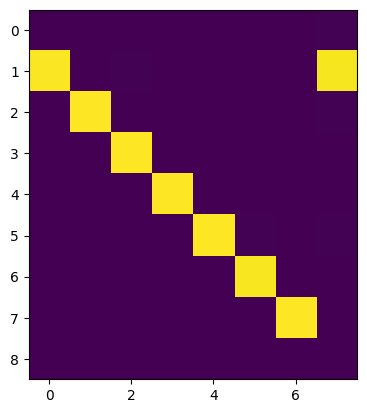

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(results[:8]).T, cmap='viridis')
plt.show()